# Amazon Fine Food Reviews Analysis

Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


<img src="NewCover.png" width="700" >

# Objective:
Given a review, determine its polarity i.e. find out that whether the review is displaying positive sentiment  or negative sentiment

# Approach

I used Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.
 
 
* cleaned the data,removed all the duplicates and column values which were making data ambigous and difficult to understand
* Data preprocessing is done using Stemming,lemmatization.
* Its a problem of text classification,so techniques of word featurization in NLP like Bag of words and TFIDF were used  
* We applied Multinomial Naive Bayes on both of them,tuned the hyperparameter alpha using 10 fold cross validation and plotted the 'AUC vs alpha' graph to determine where model is overfitting and underfitting
* Here AUC as metric was choosen because it is apt for imbalanced datasets and accuracy gives us false conclusions about the model performance sometimes
* feature engineering is performed
* Confusion matrix along with recall,precision and f1 score are displayed

# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [85]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [86]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
 

#this filters out reviews where the rating given is not 3
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [87]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [88]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [89]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [90]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [91]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [92]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [93]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [94]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [95]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [96]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [97]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)
#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [98]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both were expired! One expired back in 2005 for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez, 2 years expired!!!  I'm hoping to find local San Diego area shoppe that carries pods so that I can try something different than starbucks.
Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a do

In [106]:

import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [107]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Great ingredients although chicken should have been 1st rather than chicken broth the only thing I do not think belongs in it is Canola oil Canola or rapeseed is not someting a dog would ever find in nature and if it did find rapeseed in nature and eat it it would poison them Today is Food industries have convinced the masses that Canola oil is a safe and even better oil than olive or virgin coconut facts though say otherwise Until the late 70 is it was poisonous until they figured out a way to fix that I still like it but it could be better 


In [108]:
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [109]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████| 364171/364171 [02:38<00:00, 2300.48it/s]


In [110]:
j = preprocessed_reviews[2]
print(j)

print(len(j))


fun way children learn months year learn poems throughout school year like handmotions invent poem
98


# Applying Multinomial Naive Bayes

The multinomial Naive Bayes classifier is suitable for classification with discrete features (e.g., word counts for text classification). The multinomial distribution normally requires integer feature counts.Here we are using two featurization techniques non binary BAG of Words where the features can take any discrete value and TFIDF where values taken by features are fractional counts

## [5.1] Applying Naive Bayes on BOW

In [111]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import model_selection
from sklearn.metrics import roc_auc_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_curve



# Splitting the data

In [112]:
X_train, X_test, y_train, y_test = train_test_split(preprocessed_reviews,final['Score'], test_size=0.3) 
#This is a random splitting with data divided in ratio of 70 percent taken as training dataset and 30 percent as test dataset

print('number of points in training dataset are {}'.format(len(X_train)))
print('number of points in test dataset are {}'.format(len(X_test)))

number of points in training dataset are 254919
number of points in test dataset are 109252


# Bag of Words Featurization

In [113]:
count_vect = CountVectorizer() # from scikit learn
count_vect.fit(X_train,y_train)#vectorizer learning all the vocablury from trainning data 


train_set_bow = count_vect.transform(X_train)#transforming the  training data
test_set_bow = count_vect.transform(X_test)#transforming the test data

print('After Vectorizations:\n')
print('dimensions of training data:')
print(train_set_bow.shape,len(y_train))
print('dimesnions of test data:')
print(test_set_bow.shape,len(y_test))

After Vectorizations:

dimensions of training data:
(254919, 97158) 254919
dimesnions of test data:
(109252, 97158) 109252


# Feature engineering

Feature engineering is about creating new input features from the existing ones.it can be though of as a process of addition.This is often one of the most valuable tasks done to improve model performance

In [114]:
from scipy.sparse import hstack
# length of preprocessed reviews to be considered as another feature
length = []
for i in range(len(X_train)):
    j  = X_train[i].split()
    length.append(len(j))
    

# adding another column of length of reviews to the sparse matrices
train_set = hstack((train_set_bow,np.array(length)[:,None]))
print(train_set.shape)

(254919, 97159)


In [115]:
#length of preprocessed reveiws in test dataset
length = []
for i in range(len(X_test)):
    j  = X_test[i].split()
    length.append(len(j))
    

# adding another column of length of reviews to the sparse matrices
test_set = hstack((test_set_bow,np.array(length)[:,None]))
print(test_set.shape)

(109252, 97159)


so we are considering length of the reviews after their preprocessing as another feature 

# 10 fold cross validation for Hyperparameter tuning

In [116]:
values = [10**i for i in range(-6,7)]
train_auc = []
cv_auc = []
#tqdm bar displays the status
for i in (values):
    nb = MultinomialNB(alpha=i)
    scores = cross_val_score(nb,train_set,y_train,cv = 10,scoring = 'roc_auc')
    cv_auc.append(scores.mean())
    nb.fit(train_set,y_train)
    pred_tr = nb.predict_proba(train_set)[:,1]
    train_auc.append(roc_auc_score(y_train,pred_tr))



Maximum AUC on cv is 0.9234829841021451
best hyperparameter is 0.1


Text(0.5,1,'AUC vs Alpha')

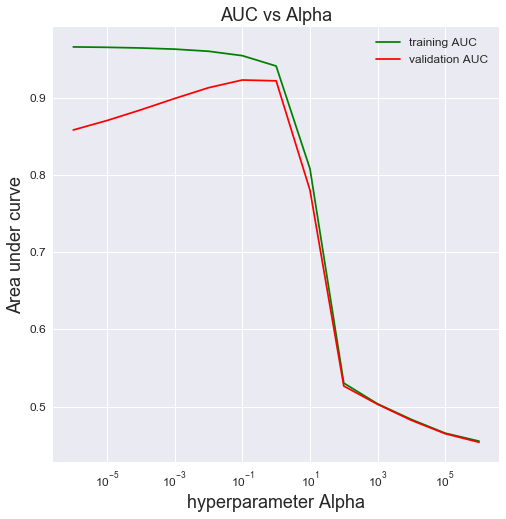

In [117]:
best_alpha = values[cv_auc.index(max(cv_auc))]
print('Maximum AUC on cv is {}'.format(max(cv_auc)))
print('best hyperparameter is {}'.format(best_alpha))
sns.set_style('darkgrid')
plt.figure(figsize=(8,8))
plt.plot(values,train_auc,'g',label = 'training AUC')
plt.plot(values,cv_auc,'r',label='validation AUC')
plt.xscale('log')
plt.xlabel('hyperparameter Alpha',fontsize=18)
plt.ylabel('Area under curve',fontsize=18)
plt.legend(loc = 'best')
plt.title('AUC vs Alpha',fontsize=18)

# AUC on test data

In [118]:


nb_optimal = MultinomialNB(alpha=best_alpha)
clf = nb_optimal.fit(train_set,y_train)
train_pred = clf.predict_proba(train_set)[:,1]
pred = nb_optimal.predict(test_set)
test_pred = clf.predict_proba(test_set)[:,1]
test_auc_bow = roc_auc_score(y_test,test_pred)
print('AUC on test data is {}'.format(test_auc_bow))

bow_best_alpha = best_alpha

AUC on test data is 0.9238164726133573


# ROC curve

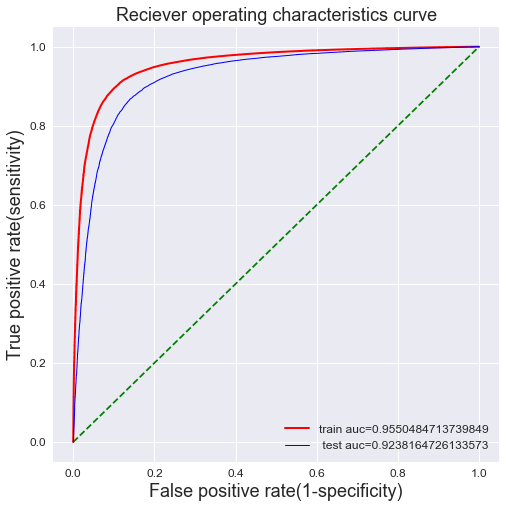

In [119]:
fpr_tr, tpr_tr, _ = roc_curve(y_train,train_pred)
fpr_test, tpr_test, _ = roc_curve(y_test,test_pred)
auc_train = roc_auc_score(y_train,train_pred)
auc_test = roc_auc_score(y_test, test_pred)
sns.set_style('darkgrid')
plt.figure(figsize=(8,8))
plt.plot(np.linspace(0,1,100),np.linspace(0,1,100),"g--")
plt.plot(fpr_tr,tpr_tr,'r',linewidth=2,label="train auc="+str(auc_train))
plt.plot(fpr_test,tpr_test,'b',linewidth=1,label=" test auc="+str(auc_test))
plt.xlabel('False positive rate(1-specificity)',fontsize=18)
plt.ylabel('True positive rate(sensitivity)',fontsize=18)
plt.title('Reciever operating characteristics curve',fontsize=18)
plt.legend(loc='best')
plt.show()
   

precision score is : 0.9482208804094112
recall score is : 0.9399700175983662
F1 score is : 0.9440774220297098
Confusion Matrix :
 [ [TN  FP]
 [FN TP] ]



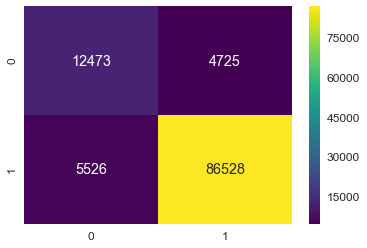

In [120]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
matrix = pd.DataFrame(confusion_matrix(y_test,pred),range(2),range(2))
print('precision score is : {}'.format(precision_score(y_test,pred)))
print('recall score is : {}'.format(recall_score(y_test,pred)))
print('F1 score is : {}'.format(f1_score(y_test,pred)))
print("Confusion Matrix :\n [ [TN  FP]\n [FN TP] ]\n")
sns.set(font_scale = 1.2)#label size
sns.heatmap(matrix,annot=True,fmt = 'g',cmap='viridis')
            

# Top 10 important features of positive class 

In [121]:
#to check which array belong to which class
clf.classes_

array([0, 1], dtype=int64)

we see that first class is negative and seconda class is positive

In [122]:
clf = nb_optimal.fit(train_set_bow,y_train)
positive_class = clf.feature_log_prob_[1]
indices = (np.argsort(positive_class)[::-1])
features = count_vect.get_feature_names()
print('TOP 10 important features of positive class and their logarithmic probabilities in Bag of Words featurization are:\n')
for i in (indices[0:10]):
    print("%s\t -->\t%f  "%(features[i],positive_class[i]))

TOP 10 important features of positive class and their logarithmic probabilities in Bag of Words featurization are:

not	 -->	-3.725212  
like	 -->	-4.563213  
good	 -->	-4.679797  
great	 -->	-4.742582  
one	 -->	-4.895063  
taste	 -->	-4.964791  
product	 -->	-5.063024  
tea	 -->	-5.066895  
flavor	 -->	-5.077979  
love	 -->	-5.079495  


#  Top 10 important features of negative class 

In [123]:
negative_class = clf.feature_log_prob_[0]
indices = (np.argsort(negative_class)[::-1])
print('TOP 10 important features of negative class and their logarithmic probabilities in Bag of Words featurization are:')
for i in (indices[:10]):
    print("%s\t -->\t%f  "%(features[i],negative_class[i]))


TOP 10 important features of negative class and their logarithmic probabilities in Bag of Words featurization are:
not	 -->	-3.270838  
like	 -->	-4.406035  
product	 -->	-4.656097  
would	 -->	-4.658682  
taste	 -->	-4.692265  
one	 -->	-4.873999  
good	 -->	-5.113202  
no	 -->	-5.139759  
flavor	 -->	-5.169914  
coffee	 -->	-5.174032  


## [5.2] Applying Naive Bayes on TFIDF

In [124]:
tfidf_vect = TfidfVectorizer(ngram_range = (1,2),min_df = 10)
tfidf_vect.fit(X_train,y_train)
train_set_tfidf = tfidf_vect.transform(X_train)
test_set_tfidf = tfidf_vect.transform(X_test)

print('AFTER VECTORIZATION:\n')
print('trainig dataset:')
print(train_set_tfidf.shape,len(y_train))
print('test dataset:')
print(test_set_tfidf.shape,len(y_test))

AFTER VECTORIZATION:

trainig dataset:
(254919, 144466) 254919
test dataset:
(109252, 144466) 109252


# Feature engineering

In [125]:
from scipy.sparse import hstack
# length of preprocessed reviews to be considered as another feature
length = []
for i in range(len(X_train)):
    j  = X_train[i].split()
    length.append(len(j))
    

# adding another column of length of reviews to the sparse matrices
train_set = hstack((train_set_tfidf,np.array(length)[:,None]))
print(train_set.shape)

(254919, 144467)


In [126]:
#length of preprocessed reveiws in test dataset
length = []
for i in range(len(X_test)):
    j  = X_test[i].split()
    length.append(len(j))
    

# adding another column of length of reviews to the sparse matrices
test_set = hstack((test_set_tfidf,np.array(length)[:,None]))
print(test_set.shape)

(109252, 144467)


# 10 fold cross validation for hyperparameter tuning

In [127]:
values = [10**i for i in range(-6,7)]
train_auc = []
cv_auc = []

for i in (values):
    nb = MultinomialNB(alpha=i)
    scores = cross_val_score(nb,train_set,y_train,cv = 10,scoring = 'roc_auc')
    cv_auc.append(scores.mean())
    nb.fit(train_set,y_train)
    pred_tr = nb.predict_proba(train_set)[:,1]
    train_auc.append(roc_auc_score(y_train,pred_tr))

Maximum AUC on cv is 0.9610684748696802
best hyperparameter is 0.1


Text(0.5,1,'AUC vs Alpha')

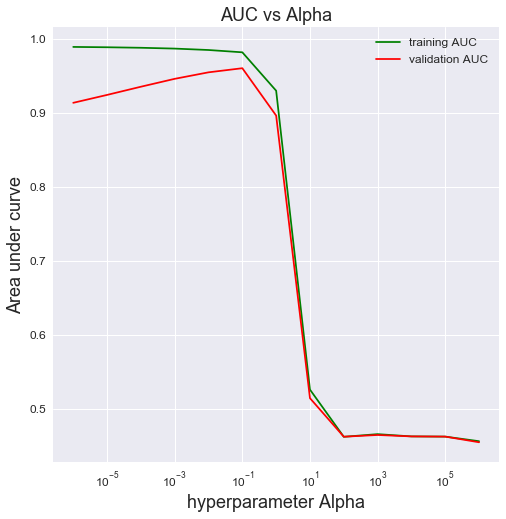

In [128]:
best_alpha = values[cv_auc.index(max(cv_auc))]
print('Maximum AUC on cv is {}'.format(max(cv_auc)))
print('best hyperparameter is {}'.format(best_alpha))
sns.set_style('darkgrid')
plt.figure(figsize=(8,8))
plt.plot(values,train_auc,'g',label = 'training AUC')
plt.plot(values,cv_auc,'r',label='validation AUC')
plt.xscale('log')
plt.xlabel('hyperparameter Alpha',fontsize=18)
plt.ylabel('Area under curve',fontsize=18)
plt.legend(loc = 'best')
plt.title('AUC vs Alpha',fontsize=18)

# AUC on test data

In [129]:
nb_optimal = MultinomialNB(alpha=best_alpha)
clf = nb_optimal.fit(train_set,y_train)
pred = clf.predict(test_set)
train_pred = clf.predict_proba(train_set)[:,1]
test_pred = clf.predict_proba(test_set)[:,1]
test_auc_tfidf = roc_auc_score(y_test,test_pred)
print('AUC on test data is {}'.format(test_auc_tfidf))

tfidf_best_alpha = best_alpha


AUC on test data is 0.9600983186696621


# ROC curve

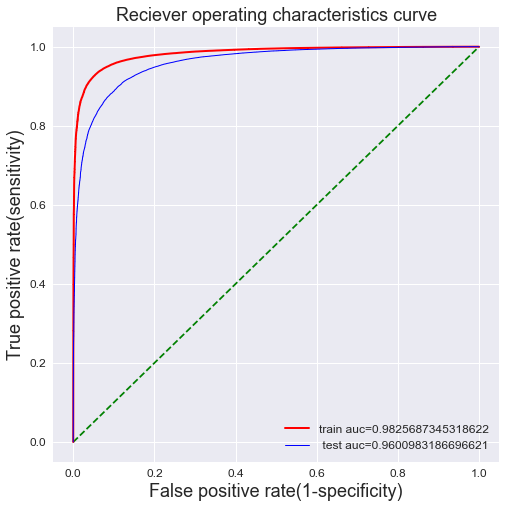

In [130]:
fpr_tr, tpr_tr, _ = roc_curve(y_train,train_pred)
fpr_test, tpr_test, _ = roc_curve(y_test,test_pred)
auc_train = roc_auc_score(y_train,train_pred)
auc_test = roc_auc_score(y_test, test_pred)
sns.set_style('darkgrid')
plt.figure(figsize=(8,8))
plt.plot(np.linspace(0,1,100),np.linspace(0,1,100),"g--")
plt.plot(fpr_tr,tpr_tr,'r',linewidth=2,label="train auc="+str(auc_train))
plt.plot(fpr_test,tpr_test,'b',linewidth=1,label=" test auc="+str(auc_test))
plt.xlabel('False positive rate(1-specificity)',fontsize=18)
plt.ylabel('True positive rate(sensitivity)',fontsize=18)
plt.title('Reciever operating characteristics curve',fontsize=18)
plt.legend(loc='best')
plt.show()
   

# Confusion Matrix

precision score is : 0.9254901960784314
recall score is : 0.9844656397332001
F1 score is : 0.9540673986966637
Confusion Matrix :
 [ [TN  FP]
 [FN TP] ]



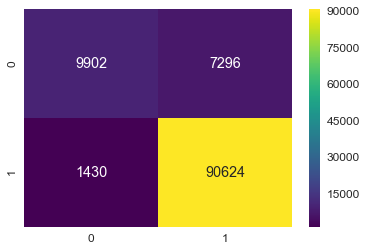

In [131]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
matrix = pd.DataFrame(confusion_matrix(y_test,pred),range(2),range(2))
print('precision score is : {}'.format(precision_score(y_test,pred)))
print('recall score is : {}'.format(recall_score(y_test,pred)))
print('F1 score is : {}'.format(f1_score(y_test,pred)))
print("Confusion Matrix :\n [ [TN  FP]\n [FN TP] ]\n")
sns.set(font_scale = 1.2)#label size
sns.heatmap(matrix,annot=True,fmt = 'g',cmap='viridis')
            

In [132]:
clf = nb_optimal.fit(train_set_tfidf,y_train)

positive_class = clf.feature_log_prob_[1]
indices = (np.argsort(positive_class)[::-1])
features = tfidf_vect.get_feature_names()
print('TOP 10 important features of positive class and their logarithmic probabilities in TFIDF featurization are:')
for i in (indices[:10]):
    print("%s\t -->\t%f  "%(features[i],positive_class[i]))

TOP 10 important features of positive class and their logarithmic probabilities in TFIDF featurization are:
not	 -->	-5.526612  
great	 -->	-5.877727  
good	 -->	-5.948601  
like	 -->	-6.010153  
coffee	 -->	-6.085021  
tea	 -->	-6.086596  
love	 -->	-6.120178  
product	 -->	-6.204080  
taste	 -->	-6.233788  
one	 -->	-6.242699  


In [133]:
negative_class = clf.feature_log_prob_[0]
indices = (np.argsort(negative_class)[::-1])
print('TOP 10 important features of negative class and their logarithmic probabilities in TFIDF featurization are:')
for i in (indices[:10]):
    print("%s\t -->\t%f  "%(features[i],negative_class[i]))


TOP 10 important features of negative class and their logarithmic probabilities in TFIDF featurization are:
not	 -->	-4.986320  
like	 -->	-5.812936  
product	 -->	-5.885547  
taste	 -->	-5.929714  
would	 -->	-5.936255  
one	 -->	-6.214301  
coffee	 -->	-6.218414  
no	 -->	-6.328513  
flavor	 -->	-6.372262  
good	 -->	-6.458222  


In [136]:
from prettytable import PrettyTable


x = PrettyTable()



x.field_names = ["featurization", "best hyperparameter(alpha)", 'AUC']

x.add_row(["Bag of Vectors",bow_best_alpha,test_auc_bow])
x.add_row(["TF-IDF",tfidf_best_alpha,test_auc_tfidf])

print(x)

+----------------+----------------------------+--------------------+
| featurization  | best hyperparameter(alpha) |        AUC         |
+----------------+----------------------------+--------------------+
| Bag of Vectors |            0.1             | 0.9238164726133573 |
|     TF-IDF     |            0.1             | 0.9600983186696621 |
+----------------+----------------------------+--------------------+


# Conclusion

* Naive Bayes is much faster classification algorithm on high dimension data.it's runtime complexity,train time complexity and run time space are low
* 'not' seems to be the most important feature in classifying reviews as positive and negative in both of the featurizations
* length of the preprocessed reviews was taken as another feature for increasing the performance of the model
* best AUC on test set is given by TFIDF featurization with AUC of 0.9660098
